In [ ]:
###
    # This code is about the Scatterplots of the seasonal sensitivity of frozen ground area in the upper (a) 1.6 m, (b) 2.4 m and (c) 3.2 m ground 
    # versus the seasonal sensitivity of soil temperature at corresponding depths, averaged over the maximum permafrost zone across northern Eurasia. 
    # Seasonal sensitivity of soil temperature is read from "../Data/Ts_seasonal_sensitivity/",calculate from "../Process/05*.py"
    # Seasonal sensitivity of frozen fround area is calculated in the following.
    # Output: Figure 1.
###

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from math import ceil
import string
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [2]:
def area_weight_mean(data2D, lat, lon):
    """
    Calculate the area-weighted mean of 2D data, taking into account grid cell areas.
    
    Parameters:
    data2D: ndarray
        Variable for area-weighted averaging, with shape [lat, lon].
    lat: ndarray
        Latitude array, 1D, in degrees.
    lon: ndarray
        Longitude array, 1D, in degrees.
    
    Returns:
    float
        Area-weighted mean of the data.
    """
    # Convert latitude to radians
    rad = np.pi / 180.0
    lat_rad = lat * rad

    # Calculate latitude and longitude resolution
    re = 6371220.0  # Earth radius (in meters)
    dlon = np.abs(lon[1] - lon[0]) * rad  # Longitude resolution (in radians)
    dlat = np.abs(lat[1] - lat[0]) * rad  # Latitude resolution (in radians)

    # Calculate the area of each grid cell
    sin_lat1 = np.sin(lat_rad + dlat / 2)
    sin_lat2 = np.sin(lat_rad - dlat / 2)
    grid_areas = (re ** 2) * dlon * (sin_lat1 - sin_lat2)[:, np.newaxis]  # (lat, lon)

    # Calculate weighted mean
    valid_mask = ~np.isnan(data2D)  # Valid data mask
    weighted_sum = np.nansum(data2D * grid_areas * valid_mask)  # Sum of weighted values
    total_weight = np.nansum(grid_areas * valid_mask)  # Sum of weights

    # If total weight is 0 (all NaN), return NaN
    if total_weight == 0:
        return np.nan

    return weighted_sum / total_weight

In [21]:
# Constants
LETTERS = list(string.ascii_lowercase)[:3]
depths = ["1.6m", "2.4m", "3.2m"]
MARKERS = ['o', 's', '^']
COLORS = plt.cm.tab20b(np.linspace(0, 1, 18))

def plot_sensitivity(ss, fs, model, i):
    ss, fs = np.array(ss, dtype=np.float64), np.array(fs, dtype=np.float64).flatten()
    df = pd.DataFrame({'x': ss, 'y': fs}).sort_values('x')
    
    # Perform linear regression
    ols_model = ols('y ~ x', data=df).fit()
    r, p_value = pearsonr(ss, fs)
    print(p_value)
    
    ax = axs[i]  
    # Add lables for each plot  
    ax.text( -0.15, 1.02, 
            f"{LETTERS[i]}",
            transform=ax.transAxes,
            fontproperties=FontProperties(weight='bold', size=15), 
            verticalalignment='bottom',
            color='black')
    ax.set_title(depths[i], fontsize=15, color='black')

    if i == 1:
        ax.set_xlabel("Seasonal sensitivity of soil temperature (°C/°C)", fontsize=15, labelpad=10)
    if i == 0:
        ax.set_ylabel("Seasonal sensitivity of frozen ground area (%/°C)", fontsize=15, labelpad=15)

    pred = ols_model.get_prediction(df).summary_frame(alpha=0.05)
    ax.plot(df['x'].values, pred['mean'].values, color='red', linewidth=2, linestyle='--')
    ax.fill_between(df['x'].values, pred['mean_ci_lower'].values, pred['mean_ci_upper'].values, color='red', alpha=0.2)
    
    # Plot scatter points
    for idx, (s, f, color, model_name) in enumerate(zip(ss, fs, COLORS, model)):
        ax.scatter(s, f, color=color, marker=MARKERS[idx % 3], s=32, label=model_name)
    
    # Customize ticks and labels
    ax.set_ylim(-3.3,0)
    ax.set_xticks(np.arange(ceil(min(ss) * 20) / 20, ceil(max(ss) * 20) / 20, 0.05))
    yticks = np.arange(-30 / 10, 0.1, 0.5)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{y:.1f}' if y != 0 else '0' for y in yticks])
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.tick_params(axis='both', labelsize=14.5)
    ax.tick_params(axis='both', which='minor', length=4, color='grey')
    ax.tick_params(axis='both', which='major', width = 1.2)

    # Display correlation coefficient and significance
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    else:
        significance = '' 
        
    ax.text(0.59, 0.91, f"$R = {r:.2f}${significance}",transform=ax.transAxes,
            ha='left', va='center', fontsize=15)
    
    # Customize axis spines
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.1)
    
    # Add legend
    if i == 2:  # Only show the legend on the last subplot for clarity
        ax.legend(loc='lower center', bbox_to_anchor=(-0.71, -0.47), edgecolor='lightgrey', shadow=False, 
                  ncol=6, fontsize=12)

    ax.grid(True, which='major', linewidth=0.5, alpha=0.3)

    return fig

0.0032448593228490818
7.896045842158296e-06
8.147662362532636e-07


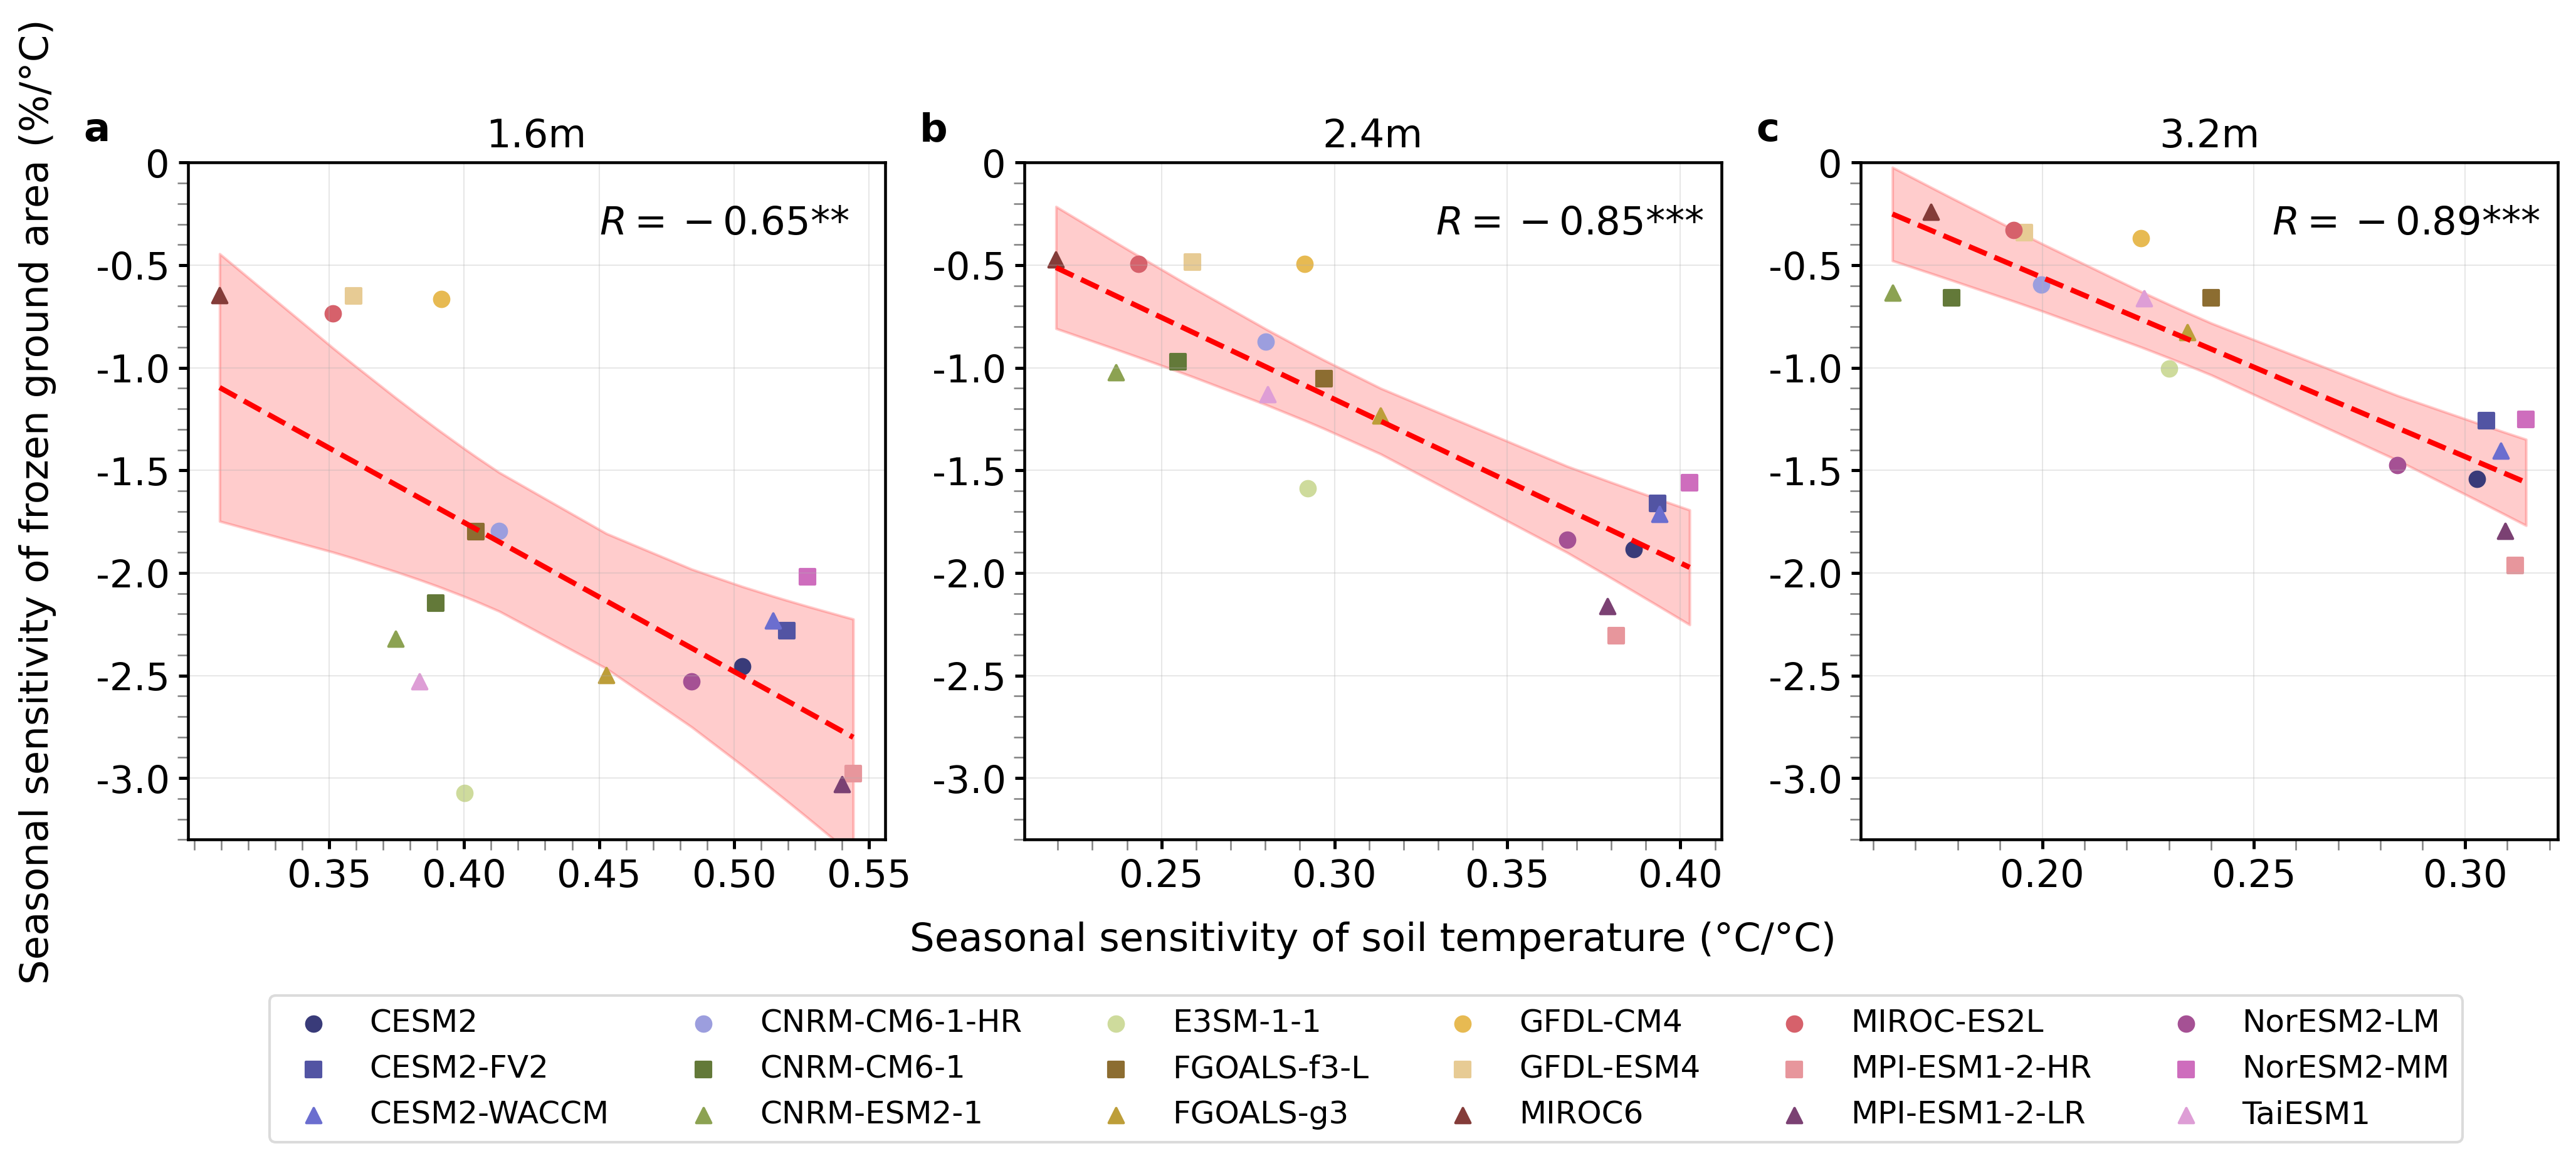

In [22]:
# Plot correlation between seasonal sensitivity of frozen ground area and soil temperature
fig, axs = plt.subplots(1, 3, figsize=(14, 6), dpi=300)
# Initialize counter for plotting
d = 0

models = [ "CESM2", "CESM2-FV2", "CESM2-WACCM","CNRM-CM6-1-HR",
               "CNRM-CM6-1", "CNRM-ESM2-1", "E3SM-1-1", "FGOALS-f3-L", "FGOALS-g3", "GFDL-CM4", "GFDL-ESM4", "MIROC6",
               "MIROC-ES2L", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "NorESM2-LM", "NorESM2-MM", "TaiESM1"]

for depth in [1.6,2.4,3.2]:
    # Load the permafrost probability data for the given depth
    q = xr.open_dataset('../Data/Probability_pf/probability_lt_threshold_'+str(int(depth*100))+'.nc')
    per_extent = q['probability_lt_threshold'][:,:360] # longitude limited to 0-180° Eurasian continent portion

    # Initialize DataFrames to store seasonal permafrost and temperature sensitivity values
    seasonal_pf = pd.DataFrame(columns = ['year'])
    seasonal_Ts = pd.DataFrame(columns = ['year'])
    for i in range (33):
        seasonal_pf.loc[i] = i+1982
        seasonal_Ts.loc[i] = i+1982

    # Seasonal Ts and Pfarea sensitivity for each model
    means_df = pd.DataFrame(columns=['Model', 'y_mean', 'sea_Ts'])
    for i in range(len(models)):
        modelname = models[i]

        Ts_file = '../Data/Ts_seasonal_sensitivity/Simulated_grid_sensitivity/'+str(int(depth*100))+'/' + modelname + '_tsl_seasonalcycle_avg.nc'
        g = xr.open_dataset(Ts_file)
        tsl_seasonalcycle_avg2 = g['tsl_seasonalcycle_avg']
        lat = g["lat"]
        lon = g["lon"]

        # Seasonal-scale soil temperature sensitivity masked by per_extent probability
        tsl_seasonalcycle_avg2 = xr.where(per_extent==0, np.nan, tsl_seasonalcycle_avg2)
        tsl_seasonalcycle_avg2 = xr.where(per_extent==1, np.nan, tsl_seasonalcycle_avg2)
        weighted_mean = area_weight_mean(tsl_seasonalcycle_avg2, lat.data, lon.data)

        #---------------------------------------------------------------------------------------------------------------------------------------
        #                       Seasonal sensitivity of frozen ground area
        #---------------------------------------------------------------------------------------------------------------------------------------
        seasonal_pf[modelname] = ''
        # Load and process the area
        pfarea_file = "../Data/Permafrost_area_timeseries_ssp585/cmip6_alt"+str(int(depth*100))+"cm_NH45_EA0_180_pfarea_1850_2100_monthly/"+modelname+"_pfarea_NH45_1850_2100monthly.nc"
        pfarea_file2 = "../Data/Permafrost_area_timeseries_ssp585/cmip6_alt"+str(int(depth*100))+"cm_NH45_EA350_360_pfarea_1850_2100_monthly/"+modelname+"_pfarea_NH45_1850_2100monthly.nc"
        pfarea1 = Dataset(pfarea_file)['pfarea'][1584:1980]/10**12 #1982-2014 EA0-180 lon
        pfarea2 = (Dataset(pfarea_file2)['pfarea'][1584:1980]/10**12).filled(np.nan) #1982-2014 EA350-360 lon 
        
        pf1 = pd.DataFrame(columns = ['year','month'])
        nmonth = 12*(2014-1982+1)
        for j in range (nmonth):
            pf1.loc[j] = int(j/12)+1982
            pf1.month.loc[j] = j%12+1
        pf1[modelname] = np.nansum([pfarea1,pfarea2], axis=0)
        dfyears = pf1.groupby(['year'])
        dfyear = [dfyears.get_group(x) for x in dfyears.groups]

        # Load temperature data for seasonal calculations
        ts_file = glob.glob("/home/wangjx/Data/cmip6_tsl_05_depth_interpolated/" + modelname+"_*.nc")[0]
        f = xr.open_dataset(ts_file,decode_times=False)
        tsl = f['tsl'][:,1,:,:360] # 0.2m Ts

        # Using 0.2m soil temperature tsl_sea_fg_area[time,lat,lon] 
        tsl_sea_fg_area = np.where(per_extent == 1, np.nan, tsl[:,:,:]) # mask 0.2mTs where there's completely continuous permafrost
        tsl_sea_fg_area_means = np.array([area_weight_mean(tsl_sea_fg_area[t,:,:], lat.data, lon.data) for t in range(np.shape(tsl_sea_fg_area)[0])])
        
        # Calculate year by year
        for k in range(len(dfyear)):
            minmonth = dfyear[k].idxmin(axis = 0)[2] # Find the index of the month with minimum permafrost area in a year
            maxmonth = dfyear[k].idxmax(axis = 0)[2] # Find the index of the month with maximum permafrost area in a year
            tsl_annualmax = tsl_sea_fg_area_means[k*12:k*12+12].max()# Highest 0.2mTs in a year
            tsl_annualmin = tsl_sea_fg_area_means[k*12:k*12+12].min()# Lowest 0.2mTs in a year
            
            # Percentage of seasonal variation in permafrost area / seasonal variation in 0.2m soil temperature
            seasonal_pf[modelname].loc[k] = (dfyear[k].loc[minmonth,:][modelname]-dfyear[k].loc[maxmonth,:][modelname])/dfyear[k].loc[maxmonth,:][modelname]*100/(tsl_annualmax-tsl_annualmin)
        
        # Calculate multi-year average, store mean values for plotting
        new_row = pd.DataFrame([{'Model': modelname, 'y_mean': np.nanmean(seasonal_pf[modelname]), 'sea_Ts': weighted_mean}])    
        means_df = pd.concat([means_df, new_row], ignore_index=True)

    # Skip excluded models
    midx = np.array([
        model != "CanESM5" and model != "CanESM5-CanOE" and model != "IPSL-CM6A-LR"
        and model != "CAS-ESM2-0" and model != "CMCC-CM2-SR5" and model != "CMCC-ESM2"
        for model in models
    ])

    means_df.set_index('Model', inplace=True)
    means_df = means_df.loc[models]
    means_df.reset_index(inplace=True)
    
    # Plot seasonal soil temperature - seasonal permafrost area sensitivity
    plot_sensitivity(means_df['sea_Ts'][midx],means_df['y_mean'][midx], models, d)  

    d=d+1

# Adjust layout and show plot
plt.subplots_adjust(left=0.08, right=0.98,bottom=0.35, top=0.95) 
plt.show()

In [23]:
fig.savefig("../Figures/Figure1.png", bbox_inches='tight',dpi=300)